In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# A simple regression problem

## Data generation

We consider a simple regression problem where $X$ is bivariate gaussian, and $y$ is a linear function of the first coordinate, with noise.

In [2]:
def generate_without_missing_values(n_samples):
    mean = [0, 0]
    cov = [[1, 0.5], [0.5, 1]]
    X = np.random.multivariate_normal(mean, cov, size=n_samples)
    
    epsilon = 0.1 * np.random.randn(n_samples)
    y = X[:, 0] + epsilon
    
    return X, y

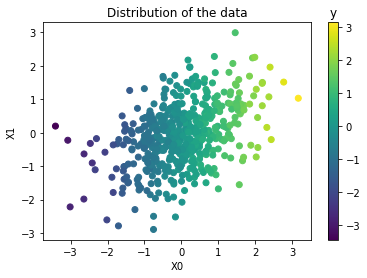

In [3]:
X, y = generate_without_missing_values(500)
plt.scatter(X[:, 0], X[:, 1], c=y);
plt.xlabel("X0")
plt.ylabel("X1")
clb = plt.colorbar()
clb.ax.set_title("y");
plt.title("Distribution of the data");

## Model evaluation

In order to evaluate an estimator, we use the learning curve: the evolution of the (cross-validated) prediction score, in function of the training size.

In [4]:
from sklearn.model_selection import learning_curve


def plot_learning_curve_without_missing_values(estimator):
    X, y = generate_without_missing_values(10 ** 7)
    sizes = np.logspace(2, 4, 5).astype(int)
    
    train_sizes, _, valid_scores = learning_curve(
        estimator, X, y, train_sizes=sizes, scoring='r2', cv=30, random_state=0)

    plt.plot(train_sizes, np.median(valid_scores, axis=1))
    plt.fill_between(train_sizes,
        np.percentile(valid_scores, q=25, axis=1),
        np.percentile(valid_scores, q=75, axis=1), alpha=0.2)
    
    plt.xscale('log')
    plt.xlabel('Sample size')
    plt.ylabel('r2 score') 
    plt.xlim(train_sizes.min(), train_sizes.max())

CPU times: user 13.4 s, sys: 1.51 s, total: 14.9 s
Wall time: 8.02 s


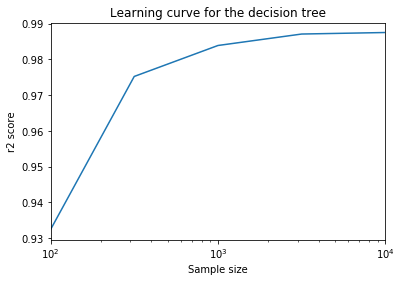

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

tree = DecisionTreeRegressor(min_samples_leaf=10)
boosting = HistGradientBoostingRegressor()

%time plot_learning_curve_without_missing_values(tree)
plt.title("Learning curve for the decision tree");
plt.show();
plt.clf();
%time plot_learning_curve_without_missing_values(boosting)
plt.title("Learning curve for the boosting");
plt.show();
plt.clf();

# Now with missing values

## Data generation: different mechanisms

In the following, we consider two missing data mechanisms: values missing completely at random (on both variables), and values missing only for high values of each variable (censor data).

In [ ]:
def generate(n_samples, mechanism):
    X, y = generate_without_missing_values(n_samples)
    
    if mechanism == 'mcar':
        missing_rate = 0.2
        M = np.random.binomial(1, missing_rate, (n_samples, 2))
    elif mechanism == 'censored':
        M = (X > 0.5)
    
    np.putmask(X, M, np.nan)
    
    return X, y

## Different models to try

We compare four missing data methods: imputation by the mean and iterative imputation (each variable is regressed from the other), with or without adding the missing data indicator. This is done both for simple trees and gradient boosted trees.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline

tree_with_mean_imputation = Pipeline([
    ('Mean imputation', SimpleImputer(strategy='mean')), 
    ('Tree', DecisionTreeRegressor(min_samples_leaf=10))
])   
tree_with_iterative_imputation = Pipeline([
    ('Iterative imputation', IterativeImputer()), 
    ('Tree', DecisionTreeRegressor(min_samples_leaf=10))
])
tree_with_mean_imputation_and_mask = Pipeline([
    ('Mean imputation and mask', SimpleImputer(strategy='mean', add_indicator=True)), 
    ('Tree', DecisionTreeRegressor(min_samples_leaf=10))
])   
tree_with_iterative_imputation_and_mask = Pipeline([
    ('Iterative imputation and mask', IterativeImputer(add_indicator=True)), 
    ('Tree', DecisionTreeRegressor(min_samples_leaf=10))
])

trees = {
    'Mean': tree_with_mean_imputation,
    'Iterative': tree_with_iterative_imputation,
    'Mean + mask': tree_with_mean_imputation_and_mask,
    'Iterative + mask': tree_with_iterative_imputation_and_mask
}

boosting_with_mean_imputation = Pipeline([
    ('Mean imputation', SimpleImputer(strategy='mean')), 
    ('Boosting', HistGradientBoostingRegressor())
])   
boosting_with_iterative_imputation = Pipeline([
    ('Iterative imputation', IterativeImputer()), 
    ('Boosting', HistGradientBoostingRegressor())
])
boosting_with_mean_imputation_and_mask = Pipeline([
    ('Mean imputation and mask', SimpleImputer(strategy='mean', add_indicator=True)), 
    ('Boosting', HistGradientBoostingRegressor())
])   
boosting_with_iterative_imputation_and_mask = Pipeline([
    ('Iterative imputation and mask', IterativeImputer(add_indicator=True)), 
    ('Boosting', HistGradientBoostingRegressor())
])

boostings = {
    'Mean': boosting_with_mean_imputation,
    'Iterative': boosting_with_iterative_imputation,
    'Mean+mask': boosting_with_mean_imputation_and_mask,
    'Iterative+mask': boosting_with_iterative_imputation_and_mask
}

## Model evaluation

We still use the learning curve, as well as a boxplot which is easier to read, extracting one slice of the learning curve.

In [ ]:
def plot_learning_curve(estimators, mechanism):
    X, y = generate(10 ** 7, mechanism)
    sizes = np.logspace(2, 4, 5).astype(int)
    
    for key, est in estimators.items():
        train_sizes, _, valid_scores = learning_curve(
            est, X, y, train_sizes=sizes, scoring='r2', cv=30, random_state=0)
        
        plt.plot(train_sizes, np.median(valid_scores, axis=1), label=key)
        plt.fill_between(train_sizes,
            np.percentile(valid_scores, q=25, axis=1),
            np.percentile(valid_scores, q=75, axis=1), alpha=0.2)
    
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Sample size')
    plt.ylabel('r2 score') 
    plt.xlim(train_sizes.min(), train_sizes.max())
    

def boxplot_scores(estimators, n_samples, mechanism):
    # one slice of the learning curve
    X, y = generate(10 ** 6, mechanism)
    
    scores = {}
    for key, est in estimators.items():
        scores[key] = learning_curve(
            est, X, y, train_sizes=[n_samples], scoring='r2', cv=30, random_state=0)[2][0]
    
    plt.boxplot(scores.values(), labels=scores.keys(), vert=False)
    plt.title('{}, sample size: {}'.format(mechanism, n_samples))
    plt.xlabel('r2 score')

### Results

When data is missing completely at random, iterative imputation (with ot without the mask) has better finite sample properties than mean imputation: it converges faster. However, for censor data, iterative imputation performs poorly without the help of the indicator, while mean imputation seems self-sufficient.

In [ ]:
%time plot_learning_curve(trees, 'mcar')
plt.title("Learning curve of the decision tree for mcar data")

In [ ]:
boxplot_scores(trees, 500, 'mcar')

In [ ]:
%time plot_learning_curve(trees, 'censored')
plt.title("Learning curve of the decision tree for censored data")

In [ ]:
boxplot_scores(trees, 500, 'censored')

In [ ]:
%time plot_learning_curve(boostings, 'mcar')
plt.title("Learning curve of the boosting for mcar data")

In [ ]:
boxplot_scores(boostings, 200, 'mcar')

In [ ]:
%time plot_learning_curve(boostings, 'censored')
plt.title("Learning curve of the boosting for censored data")

In [ ]:
boxplot_scores(boostings, 200, 'censored')